In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import db_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
metric_names = {
    'auc_rnx': '$AUC_{log}RNX$',
    'pearsonr': 'CC',
    'cca_stress': 'CCA',
    'mds_isotonic': 'nMDS',
    'sammon_nlm': 'NLM'
}

constraint_names = {
    's_all': '$S_{M+C}$',
    's_ml': '$S_{M}$',
    's_cl': '$S_{C}$'
}

def get_name_by_key(key):
    return {**metric_names, **constraint_names}[key]

dataset_names = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
#     'BREAST-CANCER95',
#     'MPI',
#     'DIABETES'
]

In [121]:
def load_scores(dataset_name = 'MNIST-SMALL', standardized=False):
    # print('Loading scores for ', dataset_name)
    db_name = 'DB_{}'.format(dataset_name)
    constraint_key_name = 'constraints'
    metric_key_name = 'metrics'

    # load metric scores and sort the record by perplexity
    dfm = db_utils.load_data(db_name, metric_key_name)
    dfm = dfm.sort_values('perp')
    # remove record with max_perp
    dfm = dfm[dfm.perp < dfm.perp.max()]

    # load constraint scores
    dfc = db_utils.load_data(db_name, constraint_key_name)
    dfc = dfc.loc[:, dfc.columns != 'reproduce_seed']
    # only work with `n_constraints > 5`
    dfc = dfc[dfc.n_constraints > 5]
    # remove record with max_perp
    dfc = dfc[dfc.perp < dfc.perp.max()]
    # group by perplexity
    dfc = dfc.groupby('perp').mean()

    perps = dfm.perp
    assert 0.0 == np.sum(perps - dfc.index)
    
    if standardized:
        # after getting the index (perp column), do standardize
        dfm = (dfm - dfm.mean()) / dfm.std()
        dfc = (dfc - dfc.mean()) / dfc.std()
    
    return perps, dfm, dfc

### Plot KL-loss by perplexity

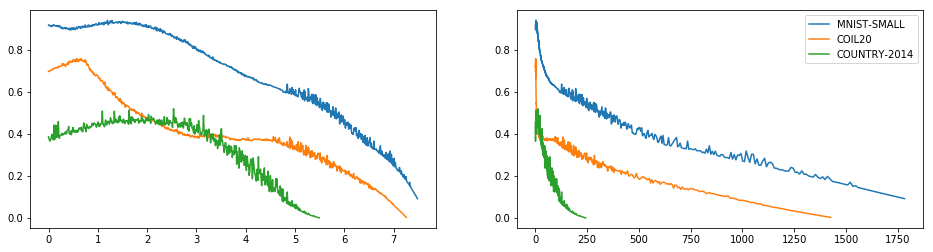

In [127]:
plt, axes = plt.subplots(1, 2, figsize=(16,4))
for dataset_name in dataset_names:
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    axes[0].plot(np.log(perps), dfm.loss, label=dataset_name)
    axes[1].plot(perps, dfm.loss, label=dataset_name)
    
axes[1].legend()

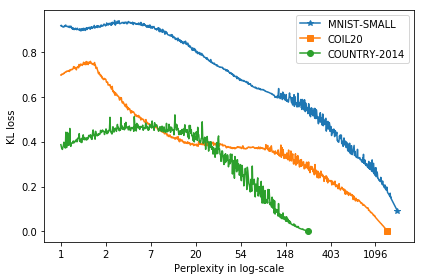

In [126]:
from matplotlib.ticker import FuncFormatter

def log_e_format(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return int(x)

fig, ax = plt.subplots(figsize=(6,4))
markers = ['*', 's', 'o']
for i, dataset_name in enumerate(dataset_names):
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    ax.semilogx(perps, dfm.loss, label=dataset_name, basex=np.e, marker=markers[i], markevery=[-1])
    ax.xaxis.set_major_formatter(FuncFormatter(log_e_format))
    ax.set_xlabel('Perplexity in log-scale')
    ax.set_ylabel('KL loss')

plt.legend()
plt.tight_layout()
plt.savefig('./plots/klloss.pdf')

### Visually compare $S_{M+C}, S_{M}, S_{C}$ with the metric scores

From the table of cosine distances between metric and constraint scores:
+ For all datasets, $S_{M+C}$ is always close to $AUC_{log}RNX$.
+ For (all) datasets, $S_M$ is always close to $CC$.
+ For (all) datasets, $S_C$ is _always_ close to $CCA$ and $nMDS$.
+ Surprisingly, $S_{M+C}$ and $S_M$ only agree with the bounded metric $AUC_{log}RNX$ and $CC$ but never with the unbounded metric $CCA, nMDS$ and $NLM$. In contrast, $S_C$ tends to agree more with the unbounded metrics.
    
![](./plots/[ALL]cosine_distance.png)    

In [86]:
colors = {
    'auc_rnx': "#651067",
    'pearsonr': "#329262",
    'cca_stress': "#5574a6",
    'mds_isotonic': "#8b0707",
    'sammon_nlm': '#e67300',
    's_all': "#ff9900",
    's_ml': "#3366cc",
    's_cl':"#dc3912"
}

In [69]:
# from scipy.spatial.distance import cosine

def _plot_lines_by_keys(dataset_name, metric_keys, constraint_keys, axis):
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    x_axis = np.log(perps)
    
    # each key has its own range value, so plot each key on it own y-axis
    def _plot_lines(df, keys):
        lines = []
        for key_name in keys:
            ax = axis.twinx()
            line, = ax.plot(x_axis, df[key_name],
                            color=colors[key_name],
                            label=get_name_by_key(key_name))
            ax.get_yaxis().set_ticks([])
            lines.append(line)
        return lines
    
    lines = []
    lines += _plot_lines(dfm, metric_keys)
    lines += _plot_lines(dfc, constraint_keys)
    axis.get_yaxis().set_ticks([])
    axis.set_title(dataset_name)
    return lines

In [82]:
def plot_lines_by_keys(metric_keys, constraint_keys, legend_loc='lower center'):
    fig, ax = plt.subplots(2, 3, figsize=(16, 6))

    for i, dataset_name in enumerate(dataset_names):
        r, c = i // 3, i % 3
        lines = _plot_lines_by_keys(dataset_name, metric_keys, constraint_keys, ax[r][c])

    plt.tight_layout()
    ax[0][0].legend(handles=lines, loc=legend_loc)

### Plot $S_{M+C}$ vs. $AUC_{log}RNX$

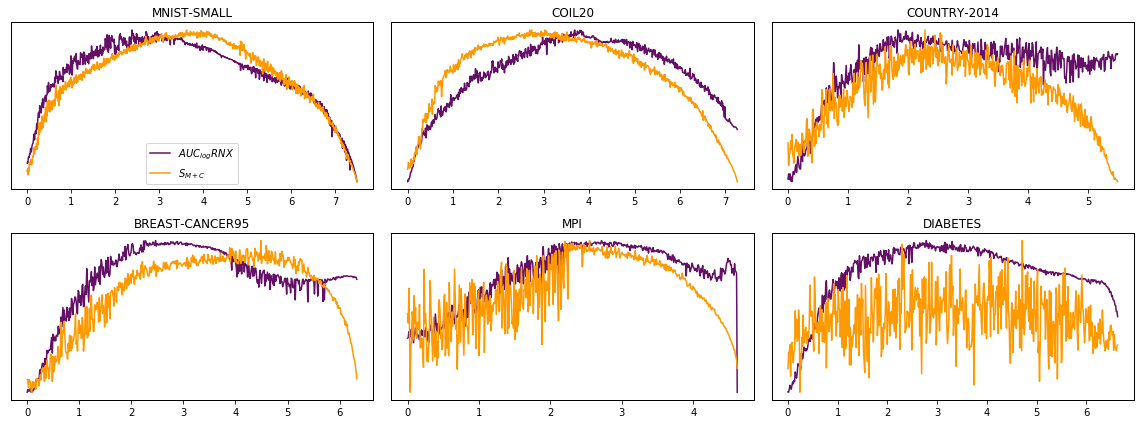

In [79]:
plot_lines_by_keys(['auc_rnx'], ['s_all'])

### Plot $S_{M}$ vs. Corr. Coeff.

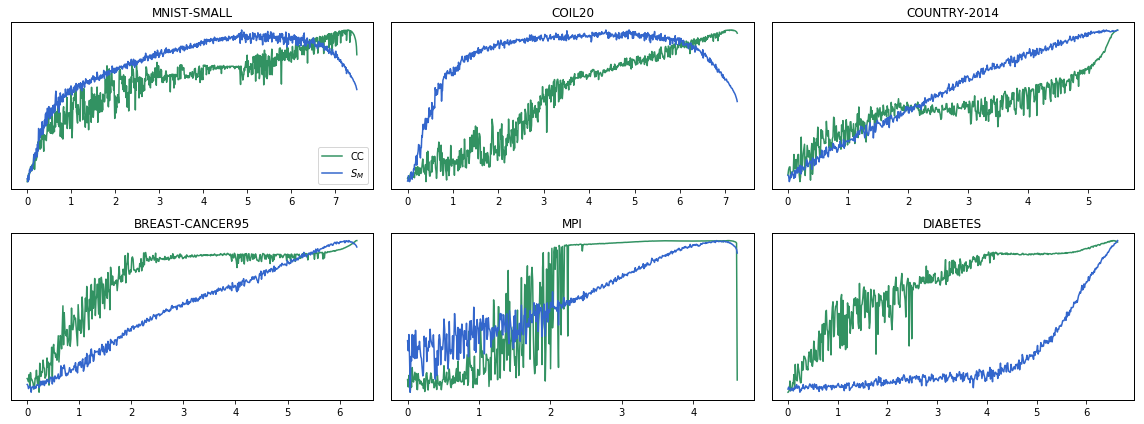

In [89]:
plot_lines_by_keys(['pearsonr'], ['s_ml'], legend_loc=4)

### Plot $S_C$ vs. $CCA$ and Non-metric MDS Stress

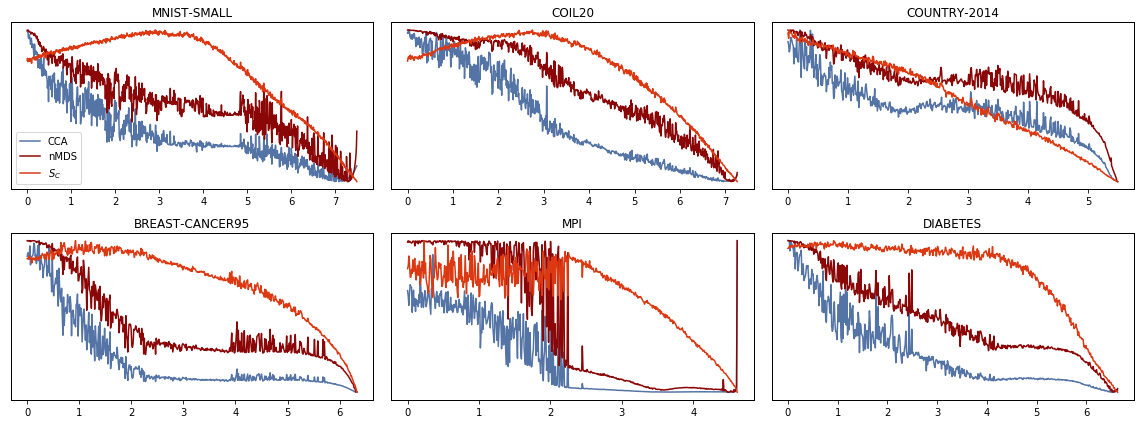

In [83]:
plot_lines_by_keys(['cca_stress', 'mds_isotonic'], ['s_cl'], legend_loc=3)

### Plot $S_M, S_C$ vs. Sammon's Non-linear mapping

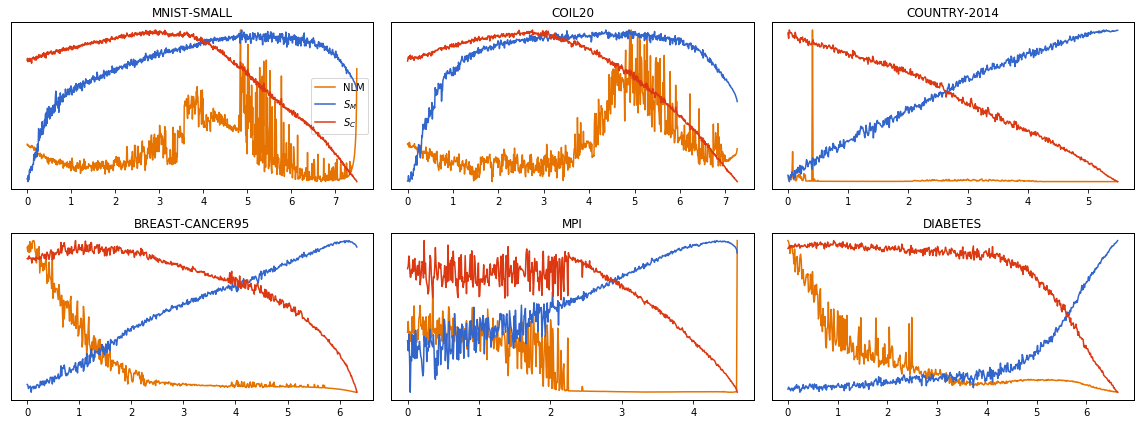

In [92]:
plot_lines_by_keys(['sammon_nlm'], ['s_ml', 's_cl'], legend_loc=5)